In [1]:
# imports
import os
import imp
import numpy as np
import pandas as pd
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bayes_mvs as bmvs

%matplotlib inline

# aliases
L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor

# data loading
headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datafile = os.path.join(headdir, 'Data/0_hvh/Clean/_summaries/model_input_with_groups.csv')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')
data = loading.default_loader(datafile)

## Basic Prototyping

In [154]:
# prototype = default_convnet

def prototype(input_var=None):
    input_shape = (None, 2, 4, 9)
    FixLayer = make_FixLayer(input_var)

    input_layer = L.InputLayer(shape=input_shape, input_var=input_var)
    network = L.Conv2DLayer(
        input_layer, num_filters=32, filter_size=(4,4), pad='full',
        nonlinearity=nl.identity
    )

    network = L.ParametricRectifierLayer(network, shared_axes='auto') # default: auto
    network = L.FeaturePoolLayer(network, pool_function=T.sum, pool_size=2) # default: T.sum, 2
    network = L.DropoutLayer(network, p=.75) # default: .75
    network = L.DenseLayer(
        network, num_units=36,
        nonlinearity=nl.very_leaky_rectify, W=lasagne.init.HeUniform(gain='relu')
    )
    network = FixLayer(network)
    network = L.NonlinearityLayer(network, nonlinearity=nl.softmax)
    network = FixLayer(network)
    network = ReNormLayer(network)

    return network

trainer = DefaultTrainer(stopthresh=100) # default: 125
net_list = trainer.train_all(architecture=prototype, data=data, seed=985227)

for i, n in enumerate(net_list):
    n.save_params(os.path.join(paramsdir, '{} split agg fit'.format(i)))

Epoch 0 took 1.533s
	training loss:			2.9994
	validation loss:		2.8461
	validation accuracy:		15.53%
	total time elapsed:		1.556s
Epoch 50 took 1.401s
	training loss:			2.1766
	validation loss:		2.1221
	validation accuracy:		34.86%
	total time elapsed:		74.468s
Epoch 100 took 1.406s
	training loss:			2.0851
	validation loss:		2.0693
	validation accuracy:		36.33%
	total time elapsed:		148.004s
Epoch 150 took 1.409s
	training loss:			2.0626
	validation loss:		2.0521
	validation accuracy:		37.11%
	total time elapsed:		222.036s
Epoch 200 took 1.379s
	training loss:			2.0516
	validation loss:		2.0408
	validation accuracy:		37.60%
	total time elapsed:		294.665s
Epoch 250 took 1.356s
	training loss:			2.0411
	validation loss:		2.0461
	validation accuracy:		37.21%
	total time elapsed:		366.784s
Epoch 300 took 1.424s
	training loss:			2.0343
	validation loss:		2.0318
	validation accuracy:		37.60%
	total time elapsed:		440.079s
Epoch 350 took 1.374s
	training loss:			2.0131
	validation loss:		2.

## Subject finetuning prototyping

In [137]:
def prototype(input_var=None):
    input_shape = (None, 2, 4, 9)
    FixLayer = make_FixLayer(input_var)

    input_layer = L.InputLayer(shape=input_shape, input_var=input_var)
    network = L.Conv2DLayer(
        input_layer, num_filters=32, filter_size=(4,4), pad='full',
        nonlinearity=nl.identity
    )

    network = L.ParametricRectifierLayer(network, shared_axes='auto') # default: auto
    network = L.FeaturePoolLayer(network, pool_function=T.sum, pool_size=4) # default: T.sum, 2
    network = L.DropoutLayer(network, p=.875) # default: .75
    network = L.DenseLayer(
        network, num_units=36,
        nonlinearity=nl.leaky_rectify, W=lasagne.init.HeUniform(gain='relu')
    )
    network = FixLayer(network)
    network = L.NonlinearityLayer(network, nonlinearity=nl.softmax)
    network = FixLayer(network)
    network = ReNormLayer(network)

    return network

class FineTuner(DefaultTrainer):
    """
    Trainer to fine tune networks to individual subjects

    Consider moving freeze, param set functions properly into Network object
    Abstracting split functions and augment in DefaultTrainer would be good too
    """

    def train_all(self, architecture, data, split=0, seed=None, startparams=None, freeze=True, save_params=False):
        if seed:
            np.random.seed(seed)

        D, groups, Xs, ys, Ss = data
        num_splits = len(Xs)
        r = np.tile(np.arange(num_splits), [num_splits, 1])
        r = (r + r.T) % num_splits

        starttime = time.time()
        net = Network(architecture)
        if startparams:
            _layers = L.get_all_layers(net.net)[1:3]
            L.set_all_param_values(net.net, startparams)#(_layers, startparams[0:3])
            convlayer, prelulayer = _layers
            if freeze:
                convlayer.params[convlayer.W].remove('trainable')
                convlayer.params[convlayer.b].remove('trainable')
                prelulayer.params[prelulayer.alpha].remove('trainable')

        train_idxs = r[split, :3]
        val_idxs = r[split, 3:4]
        test_idxs = r[split, 4:]

        X, y, S = [np.concatenate(np.array(Z)[train_idxs]) for Z in [Xs, ys, Ss]]
        Xv, yv, Sv = [np.concatenate(np.array(Z)[val_idxs]) for Z in [Xs, ys, Ss]]
        Xt, yt, St = [np.concatenate(np.array(Z)[test_idxs]) for Z in [Xs, ys, Ss]]
#         print(X.shape[0])
        if X.shape[0] > 75:
            X, y = augment((X, y))
            S = np.concatenate([S, S, S, S])
            self.train(net, training_data=(X, y), validation_data=(Xv, yv))
        self.test(net, testing_data=(Xt, yt))
        time_elapsed = time.time() - starttime

        return net


In [143]:
# TODO: save traces
# TODO: keep traces from one net to another?? or save separately and append...

# set fixed params with easy-access dicts, because we don't hate ourselves
#   also because we don't hate ourselves, maybe name these more clearly soon?

trainer_settings = {
    'stopthresh':3,
#     'updates': lasagne.updates.sgd,
    'update_args':{'learning_rate':.001}
}

trainer_args = {
    'architecture':prototype,
    'seed':985227,
}

subject_Xs = data[2]
subject_ys = data[3]
subject_Ss = data[4]
results = []
for i, net in enumerate(net_list):
    result = []
    PARAMS = L.get_all_param_values(net.net)
    
    for subno in range(40):
        S0 = [np.where(s==subno)[0] for s in subject_Ss]
        X0 = [subject_Xs[i][s] for i, s in enumerate(S0)]
        y0 = [subject_ys[i][s] for i, s in enumerate(S0)]
        sub_data = (data[0], data[1], X0, y0, S0)
        print('\nMODEL {}, SUBJECT {}, NMOVES {} per split\n'.format(i, subno, len(S0[0])))

        batchsize = len(S0[0])//2
        sub_trainer = FineTuner(batchsize=batchsize, **trainer_settings)
        sub_net = sub_trainer.train_all(data=sub_data, startparams=PARAMS, split=i, **trainer_args)
        result.append(sub_net.test_err)
        sub_net.save_params(os.path.join(paramsdir, '{} split {} sub tune fit'.format(i, subno))) # something is broken here
        # add trace saving here
        
        
    results.append(result)

res = np.array(results).T
# np.savetxt(os.path.join(resultsdir, 'nlls.txt'), res, fmt='%.18f', delimiter=',')



MODEL 0, SUBJECT 0, NMOVES 33 per split

Epoch 0 took 0.033s
	training loss:			2.5540
	validation loss:		2.0230
	validation accuracy:		50.00%
	total time elapsed:		0.035s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		4
	Test loss:			2.4379
	Test accuracy:			18.75%

MODEL 0, SUBJECT 1, NMOVES 32 per split

Epoch 0 took 0.034s
	training loss:			2.4174
	validation loss:		2.3527
	validation accuracy:		37.50%
	total time elapsed:		0.035s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		4
	Test loss:			2.2487
	Test accuracy:			37.50%

MODEL 0, SUBJECT 2, NMOVES 62 per split

Epoch 0 took 0.059s
	training loss:			2.3747
	validation loss:		1.8434
	validation accuracy:		32.26%
	total time elapsed:		0.060s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		4
	Test loss:			2.0656
	Test accuracy:			35.48%

MODEL 0, SUBJECT 3, NMOVES 60 per split

Epoch 0 took 0.065s
	training loss:			2.5295
	validation loss:		1.9990
	validation accuracy:		50.00%
	total time elapsed:		0.067s
Abandon ship!
T

In [153]:
res.mean()

2.169969110091468

In [145]:
# generate boards file

# TEMPORARY subclass - merge these functions into main network, since they are useful!
class TestNetwork(Network):
    def __init__(self, architecture):
        super(TestNetwork, self).__init__(architecture)
        self.itemized_loss = lasagne.objectives.categorical_crossentropy(self.test_prediction, self.target_var)
        self.itemized_test_fn = theano.function([self.input_var, self.target_var], self.itemized_loss)
        
    def load_params(self, paramsfile):
        with np.load(paramsfile) as loaded:
            params_list = [(i[0], i[1]) for i in loaded.items()]
            params_list.sort()
            L.set_all_param_values(self.net, [i[1] for i in params_list])
            

D = data[0].copy()
D2 = data[0].copy()
D['group'] = D['group']-1
D2['group'] = D2['group']-1
O = pd.DataFrame(index=D.index, columns=list(range(36)))
Xx, yy, Ss, Gg, Npnp = loading.unpack_data(D)
for _g in D['group'].unique():
    print('Split group: {}, Model idx: {}\n'.format(_g, (_g+1)%5))
    for _s in D['subject'].unique():
        paramsfile = os.path.join(paramsdir, '{} split {} sub tune fit.npz'.format((_g+1)%5, _s))
        locs = (D['subject']==_s)&(D['group']==_g)
        idx = D.loc[locs, :].index.values
        test_net = TestNetwork(prototype)
        test_net.load_params(paramsfile)
        
        _x = Xx[idx, :, :, :]
        _y = yy[idx]
        print(_s, test_net.test_fn(_x, _y))

        D.loc[idx, 'nll'] = test_net.itemized_test_fn(_x, _y)
        O.loc[idx, list(range(36))] = test_net.output_fn(_x)
        O.loc[idx, 'prediction'] = O.loc[idx, list(range(36))].values.argmax(axis=1)
    paramsfile = os.path.join(paramsdir, '{} split agg fit.npz'.format((_g+1)%5))
    idx = D2.loc[D2['group']==_g, :].index.values
    test_net = TestNetwork(prototype)
    test_net.load_params(paramsfile)
    
    _x = Xx[idx, :, :, :]
    _y = yy[idx]
    D2.loc[idx, 'nll'] = test_net.itemized_test_fn(_x, _y)

D = D.join(O)
D['correct'] = (D['zet']==D['prediction']).astype(int)
D.head()

Split group: 4, Model idx: 0

0 [array(2.4379192727928833), array(0.1875)]
1 [array(2.2487088114940126), array(0.375)]
2 [array(1.9878511229712656), array(0.4098360655737705)]
3 [array(2.042780241814411), array(0.3898305084745763)]
4 [array(1.9902286090541308), array(0.3888888888888889)]
5 [array(1.989001321137695), array(0.3888888888888889)]
6 [array(2.0501019545971135), array(0.5)]
7 [array(1.9933166430934586), array(0.3888888888888889)]
8 [array(2.5834887929442374), array(0.14285714285714285)]
9 [array(2.672689896078356), array(0.14285714285714285)]
10 [array(1.9658007659730754), array(0.375)]
11 [array(2.575312992242308), array(0.25)]
12 [array(2.5786779289694204), array(0.3333333333333333)]
13 [array(1.8289215043838025), array(0.41935483870967744)]
14 [array(2.2237393221041435), array(0.2702702702702703)]
15 [array(2.02557409822906), array(0.4444444444444444)]
16 [array(2.800037387737505), array(0.2692307692307692)]
17 [array(2.677839130545427), array(0.19230769230769232)]
18 [arr

,subject,color,bp,wp,zet,rt,group,nll,0,1,...,28,29,30,31,32,33,34,35,prediction,correct
0,0,0,000000000000000000000000000000000000,000000000000000000000000000000000000,11,7223,4,3.379635,0.011111,0.00609445,...,0.00674022,0.0127025,0.0149922,0.0244142,0.0145335,0.0117081,0.00501491,0.0126695,22.0,0
1,1,1,000000000000000000000000000000000000,000000000001000000000000000000000000,24,5141,4,3.797825,0.00582327,0.00650331,...,0.00834303,0.0217743,0.023073,0.0307908,0.0133102,0.00928856,0.00271548,0.0074276,12.0,0
2,0,0,000000000001000000000000000000000000,000000000000000000000000100000000000,21,3154,4,2.609140,0.00271268,0.00781341,...,0.00365816,0.0129015,0.0132157,0.0354103,0.0104756,0.0144974,0.00501939,0.00322924,12.0,0
3,1,1,000000000000000000000000100000000000,000000000001000000000100000000000000,31,5715,3,1.214792,0.00369094,0.0822021,...,0.00646663,0.0073656,0.0127253,0.296772,0.0121909,0.00879255,0.00644163,0.00370444,31.0,1
4,0,0,000000000001000000000100000000000000,000000000000000000000000100000010000,14,6837,2,3.460020,0.0035025,0.00554316,...,0.00351001,0.0336401,0.0134543,0,0.0127813,0.00351144,0.00349425,0.00349725,12.0,0


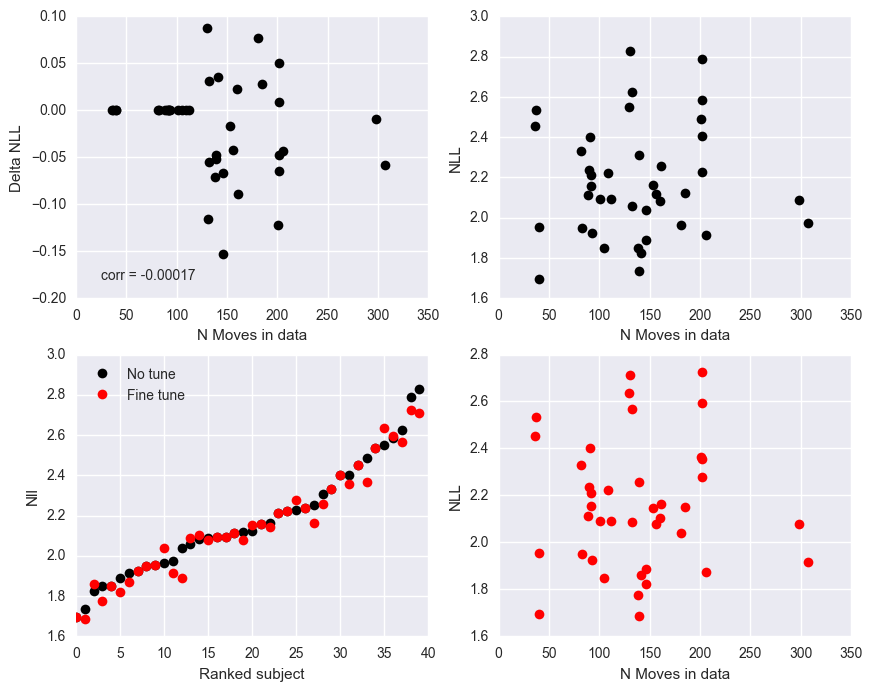

In [150]:
p = D.pivot_table(index='subject', values=['nll']).values.flatten()
p2 = D2.pivot_table(index='subject', values=['nll']).values.flatten()
diff = p - p2
lendiff = D.pivot_table(index='subject', values=['nll'], aggfunc=len).values.flatten()
order = p2.argsort()
from scipy.stats import linregress
lr = linregress(lendiff, diff)
print(lr)

fig, axes = plt.subplots(2, 2, figsize=(10,8))
ax = axes[0, 0]
ax.plot(lendiff, diff, color='black', linestyle='none', marker='o')
ax.text(25, -.18, s='corr = {:.5f}'.format(lr.slope))
plt.setp(axes[0, 0], xlabel='N Moves in data', ylabel='Delta NLL')
ax = axes[0, 1]
ax.plot(lendiff, p2, color='black', linestyle='none', marker='o')
plt.setp(ax, xlabel='N Moves in data', ylabel='NLL')
ax = axes[1, 1]
ax.plot(lendiff, p, color='red', linestyle='none', marker='o')
plt.setp(ax, xlabel='N Moves in data', ylabel='NLL')

axes[1, 0].plot(np.arange(40), p2[order], color='black', linestyle='none', marker='o', label='No tune')
axes[1, 0].plot(np.arange(40), p[order], color='red', linestyle='none', marker='o', label='Fine tune')
axes[1, 0].legend(loc=0)
plt.setp(axes[1, 0], xlabel='Ranked subject', ylabel='Nll')
sns.despine()
fig.savefig(os.path.join(resultsdir, 'overfitting viz exclude n lt 125.png'), format='png')

In [151]:
D2['nll'].mean()

2.1831384718471996

In [152]:
p2.mean()

2.1771778202326102

In [73]:
diff.shape

(40, 1)

In [121]:
D.to_csv(os.path.join(resultsdir, '(POSSIBLE BUG - NLL MISMATCH) appended data.csv'))

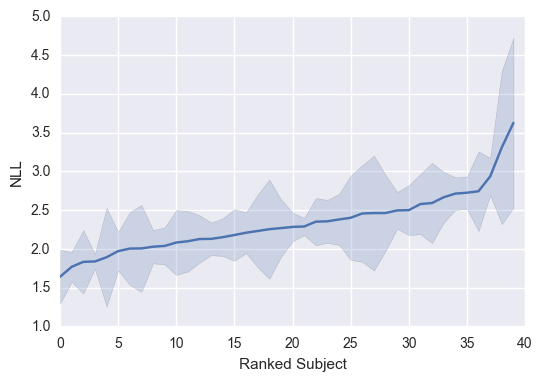

In [162]:
mos = [bmvs(res[i, :], alpha=.95) for i in range(res.shape[0])]
means = np.array([m[0][0] for m in mos])
lbs = np.array([m[0][1][0] for m in mos])
ubs = np.array([m[0][1][1] for m in mos])
idx = np.argsort(means)
plt.fill_between(x=np.arange(40), y1=lbs[idx], y2=ubs[idx], alpha=.2)
plt.plot(means[idx])
plt.setp(plt.gca(), xlabel='Ranked Subject', ylabel='NLL')
sns.despine()

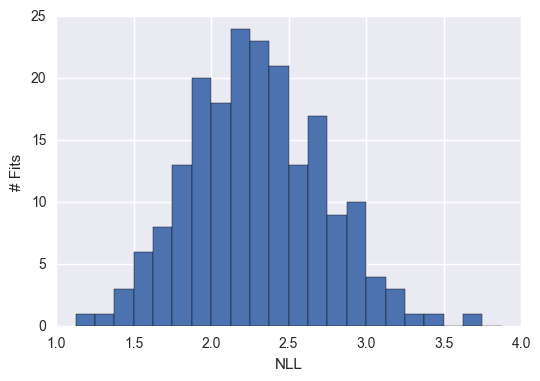

In [163]:
plt.hist(res.flatten(), bins = np.arange(1, 4, 1/8))
plt.setp(plt.gca(), xlabel='NLL', ylabel='# Fits')
sns.despine()

In [71]:
bmvs(np.array(res).flatten())

(Mean(statistic=2.0297389663420167, minmax=(1.9754359377545521, 2.0840419949294815)),
 Variance(statistic=0.21815111779251639, minmax=(0.18451519497299468, 0.25678486268659811)),
 Std_dev(statistic=0.46647415702644379, minmax=(0.42955231924993104, 0.506739442600039)))

## Autoencoder prototyping

In [ ]:
def autoencoder_prototype(input_var=None):
    input_shape = (None, 2, 4, 9)
    inpuL.InputLayer = L.InputLayer(shape=input_shape, input_var=input_var)
    network = L.COnv2DLayer(
        input_layer, num_filters=32, filter_size=(4, 4), pad='full',
        nonlinearity=nl.identity
    )
    L.ParametricRectifierLayerrLayeshared_axes=Rectifier(network, shL.FeaturePoolLayerl')
    network = L.FeaturePoolLayer(network, pool_functioL.DropoutLayerm, pool_size=2)
    network = L.DropoutLayer(network, p=.75)
    network = L.DenseLayer(
        network, num_units=72,
        nonlinearity=nl.very_leaky_rectify, W=lasagne.init.HeUniform(gain='relu')
    )
    network = L.ReshapeLayer(
        network, shape=(-1, 2, 4, 9)
    )
    return network

In [ ]:
class Autoencoder(Network):
    """
    Overwrites loss functions for training an autoencoder instead
    of softmax output classifier
    """
    def objectives(self):
        """Must define: loss, test_loss, test_acc"""
        self.loss = lasagne.objectives.squared_error(self.prediction, self.target_var)
        self.loss = self.loss.mean()
        self.test_loss = lasagne.objectives.squared_error(self.test_prediction, self.target_var)
        self.test_loss = self.test_loss.mean()
        self.test_acc = T.mean(T.abs(self.test_prediction - self.target_var))
        return None

# class AutoTrainer(DefaultTrainer):
#     """
#     Overwrites training functions for training an autoencoder instead
#     of softmax output classifier
#     """
#     pass

# Can actually pass data to existing trainer by replacing ys with a copy of Xs!

# class LadderNet(Network):
#     """
#     Loads conv layer params from autoencoder save and sets them on current classifier
#     Needs overwrite of self.build() that loads conv2d params, then sets them untrainable.
#     """
#     def __init__(self, architecture, paramsfile):
#         self.paramsfile = paramsfile
#         super(LadderNet, self).__init__(architecture)
    
#     def build(self):
#         super(LadderNet, self).build()
        
#         # Finish this soon!
#         return None
    
#     def load_conv_params(self):
#         with np.load(paramsfile) as loaded:
# #             L.